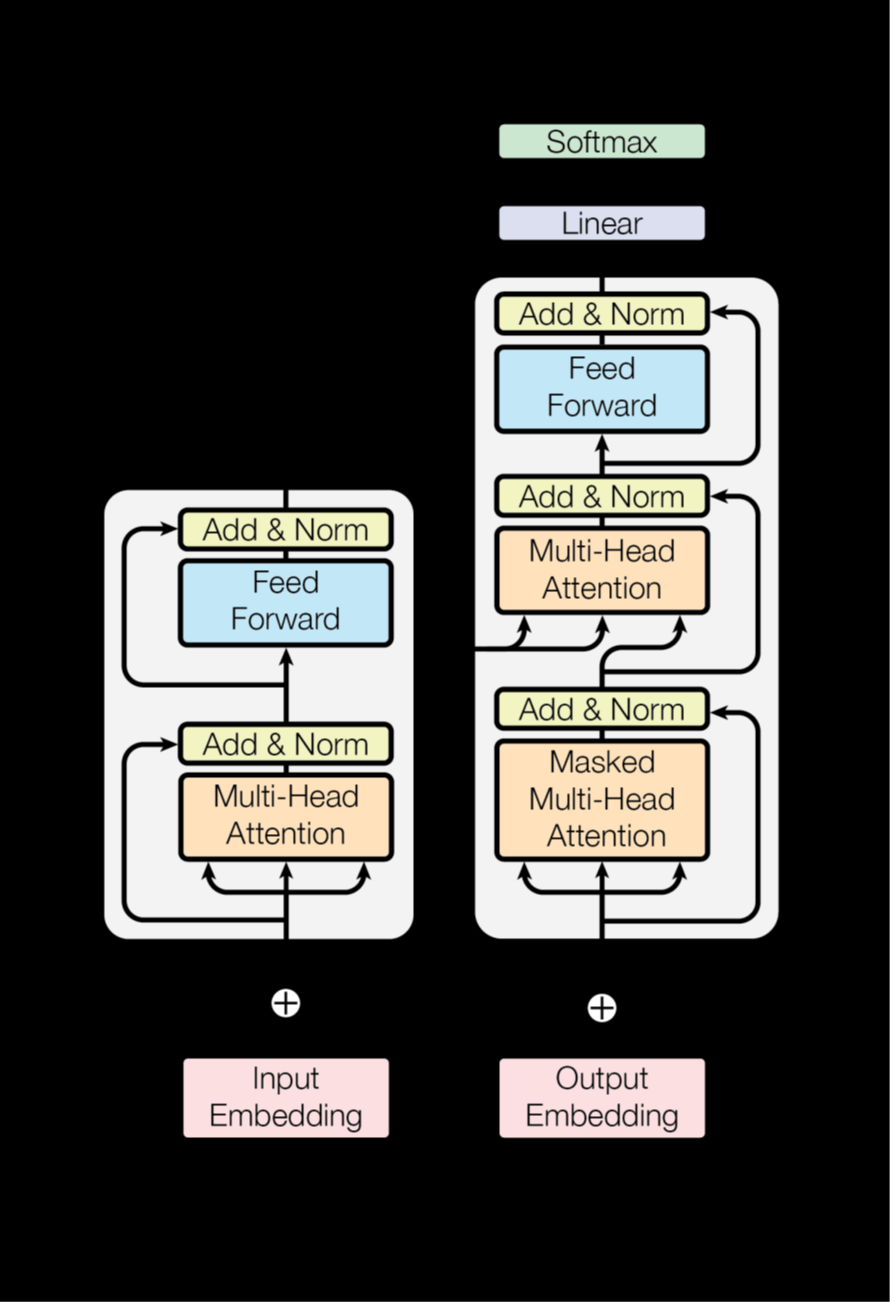

In [ ]:
!pip install -q datasets

In [ ]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from typing import Tuple, List
import pandas as pd
import numpy as np
from datasets import load_dataset
import math
from tqdm import tqdm
from transformers import MarianTokenizer
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

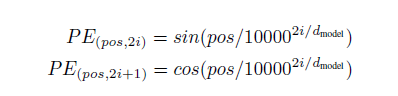

In [ ]:
class PositionEncoding(torch.nn.Module):
    """Positional Encoding for Transformer model.

    Args:
        d_model (int): Embedding dimension.
        max_len (int): Maximum length of input sequences (default 128).
        device (str): 'cpu' or 'cuda'"""

    def __init__(self, d_model: int, max_len: int = 128, device=device) -> None:
        super().__init__()
        pe = torch.zeros(max_len, d_model).to(device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1).to(device)

        div_term = 10000 ** (torch.arange(0, d_model, 2).float() / d_model).to(device)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass to add positional encoding to input embeddings.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, max_len, d_model).

        Returns:
            x (torch.Tensor): Output tensor with position encoding added to it of shape (batch_size, max_len, d_model)."""

        x = x.to(device)
        x = x + self.pe[:x.size(1), :]  # Apply positional encoding
        return x

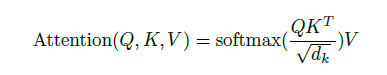

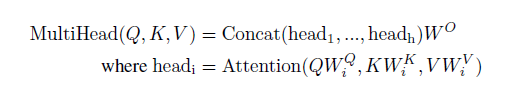

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    """Multi-head attention module.

    Args:
        d_model (int): Embedding dimension.
        num_heads (int): Number of attention heads."""

    def __init__(self, d_model: int, num_heads: int) -> None:
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(in_features=d_model, out_features=d_model)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model)

        self.W_o = nn.Linear(in_features=d_model, out_features=d_model)

    def scaled_dot_product_attention(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """Calculate scaled dot product attention.

        Args:
            query (torch.Tensor): Query tensor of shape (batch_size, num_heads, max_len, d_k).
            key (torch.Tensor): Key tensor of shape (batch_size, num_heads, max_len, d_k).
            value (torch.Tensor): Value tensor of shape (batch_size, num_heads, max_len, d_k).
            mask (torch.Tensor, optional): Optional mask tensor.

        Returns:
            Tuple:
                attn_output (torch.Tensor): Output of the attention layer.
                attn_weights (torch.Tensor): Attention weights."""

        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)  # Scaled dot product

        if mask is not None:
            # Reshape to (batch_size, 1, seq_len, seq_len)
            mask = mask.unsqueeze(1)
            # Check for expected dimensions before repeat
            if len(mask.shape) == 4:
                mask = mask.repeat(1, self.num_heads, 1, 1)
                scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = torch.softmax(scores, dim=-1)  # Softmax
        attn_output = torch.matmul(attn_weights, value)  # Weighted sum
        return attn_output, attn_weights

    def forward(self, query: torch.Tensor, key: torch.Tensor = None, value: torch.Tensor = None, mask=None) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass for Multi-head Attention.

        Args:
            query (torch.Tensor): Input tensor of shape (batch_size, max_len, d_model).
            key (torch.Tensor, optional): Key tensor (defaults to query).
            value (torch.Tensor, optional): Value tensor (defaults to query).
            mask (torch.Tensor, optional): Mask of input tensor (default None).

        Returns:
            Tuple:
                output (torch.Tensor): Output tensor of shape (batch_size, max_len, d_model).
                attn_weights (torch.Tensor): Attention weights tensor of shape (batch_size, num_heads, max_len, max_len)."""

        batch_size = query.size(0)

        if key is None:
            key = query
        if value is None:
            value = query

        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot product attention
        attn_output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # Multihead outputs
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.W_o(attn_output)
        return output, attn_weights

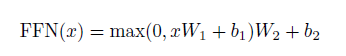

In [ ]:
class FeedForwardNetwork(nn.Module):
    """Feed-forward network module.

    Args:
        d_model (int): Embedding dimension (default 512).
        d_ff (int): Feed forward network dimension (default 2048).
        dropout (float): dropout value (default 0.1)."""

    def __init__(self, d_model: int = 512, d_ff: int = 2048, dropout: float = 0.1) -> None:
        super().__init__()
        self.ffn_block = nn.Sequential(
            nn.Linear(in_features=d_model, out_features=d_ff),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=d_ff, out_features=d_model),
        )

    def forward(self, x: torch.Tensor):
        """Forward pass for feed-forward network layer.

        Args:
            x (torch.Tensor): Tensor of shape (batch_size, max_len, d_model).

        Returns:
            x (torch.Tensor): Output tensor of shape (batch_size, max_len, d_model)."""

        x = self.ffn_block(x) + x # Feed forward network + residual input
        return x

In [ ]:
class EncoderLayer(nn.Module):
    """A single Encoder layer

    Args:
        d_model (int): Embedding dimension.
        num_heads (int): Number of attention heads.
        d_ff (int): Feed foward network dimension.
        dropout (float): Dropout value (default 0.1)."""

    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout=0.1) -> None:
        super().__init__()
        self.mha = MultiHeadSelfAttention(d_model, num_heads) # Multi-head attention
        self.layernorm1 = nn.LayerNorm(d_model) # Layer normalization
        self.dropout1 = nn.Dropout(p=dropout)
        self.ffn = FeedForwardNetwork(d_model, d_ff, dropout) # Feed forward network
        self.layernorm2 = nn.LayerNorm(d_model) # Layer normlization
        self.dropout2 = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """Forward pass for the encoder layer.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, max_len, d_model).
            mask (torch.Tensor, optional): Optional mask of input tensor (default None).

        Returns:
            x (torch.Tensor): Output tensor of shape (batch_size, max_len, d_model)."""

        attn_output, _ = self.mha(x, key=x, value=x, mask=mask) # Self attention
        x = self.layernorm1(x + self.dropout1(attn_output))  # Add and norm
        ffn_output = self.ffn(x)  # Feed forward network
        x = self.layernorm2(x + self.dropout2(ffn_output))  # Add and norm
        return x

In [ ]:
class DecoderLayer(nn.Module):
    """A single Decoder layer.

    Args:
        d_model (int): Embedding dimension.
        num_heads (int): Number of attention heads.
        d_ff (int): Feed forward network dimension.
        dropout (float): Dropout value (default 0.1)"""

    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)  # Masked MHA
        self.cross_attn = MultiHeadSelfAttention(d_model, num_heads)  # Cross-attention
        self.layernorm1 = nn.LayerNorm(d_model) # Layer Normalisation
        self.dropout1 = nn.Dropout(p=dropout)
        self.layernorm2 = nn.LayerNorm(d_model) # Layer Normalisation
        self.dropout2 = nn.Dropout(p=dropout)
        self.ffn = FeedForwardNetwork(d_model, d_ff, dropout)
        self.layernorm3 = nn.LayerNorm(d_model) # Layer Normalisation
        self.dropout3 = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, tgt_mask: torch.Tensor = None, src_mask: torch.Tensor = None) -> torch.Tensor:
        """Forward pass for decoder layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, max_len, d_model).
            encoder_output (torch.Tensor): Output tensor from the encoder, shape (batch_size, max_len, d_model).
            tgt_mask (torch.Tensor, optional): Mask tensor for target. (default None).
            src_mask (torch.Tensor, optional): Mask tensor for source. (default None).

        Returns:
            x (torch.Tensor): Output tensor of shape (batch_size, max_len, d_model)."""

        attn_output, _ = self.self_attn(x, key=x, value=x, mask=tgt_mask)  # Masked self-attention
        x = self.layernorm1(x + self.dropout1(attn_output))  # add and norm
        attn_output, _ = self.cross_attn(x, key=encoder_output, value=encoder_output, mask=src_mask) # Cross-attention
        x = self.layernorm2(x + self.dropout2(attn_output))  # add and norm
        ffn_output = self.ffn(x)  # feed forward network
        x = self.layernorm3(x + self.dropout3(ffn_output))  # add and norm
        return x

In [ ]:
class Encoder(nn.Module):
    """Encoder block.

    Args:
        d_model (int): Embedding dimension.
        d_ff (int): Feed forward network dimension.
        num_heads (int): Number of attention heads.
        max_len (int): Max length of input sequence. (default 128).
        dropout (float): Dropout value (default 0.1).
        num_layers (int): Number of encoder layers (default 6)."""

    def __init__(self, d_model: int, d_ff: int, num_heads: int, max_len: int = 128, dropout: float = 0.1, num_layers: int = 6) -> None:
        super().__init__()
        self.d_model = d_model
        self.position_encoding = PositionEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """Forward pass for the encoder block.

        Args:
            x (torch.Tensor): Input tensor of shape (d_model, max_len).
            mask (torch.Tensor, optional): Optional mask for input tensor (default None).

        Returns:
            x (torch.Tensor): Output tensor of shape (batch_size, d_model, max_len)."""

        x = self.position_encoding(x * math.sqrt(self.d_model)) # Position encoding
        x = self.dropout(x) 

        # Pass through each Encoder layer
        for layer in self.layers:
            x = layer(x, mask)

        return x

In [ ]:
class Decoder(nn.Module):
    """Decoder block.

    Args:
        d_model (int): Embedding dimension.
        d_ff (int): Feed forward network dimension.
        num_heads (int): Number of attention heads.
        max_len (int): Max length of input sequence (default 128).
        dropout (float): Dropout value (default 0.1).
        num_layers (int): Number of decoder layers (default 6).
        vocab_size (int): Vocabulary size for token embedding (default 128)."""

    def __init__(self, d_model: int, d_ff: int, num_heads: int, max_len: int = 128, dropout: float = 0.1, num_layers: int = 6, vocab_size=128) -> None:
        super().__init__()
        self.d_model = d_model
        self.position_encoding = PositionEncoding(d_model, max_len) # Position Encoding
        self.embedding = nn.Embedding(vocab_size, d_model)  # Add embedding layer
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]) # Decoder layers
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, tgt_mask: torch.Tensor = None, src_mask: torch.Tensor = None) -> torch.Tensor:
        """Forward pass for the decoder block.

        Args:
            x (torch.Tensor): Input tensor of shape (d_model, max_len).
            encoder_output (torch.Tensor): Output tensor from the encoder block, shape (batch_size, d_model, max_len).
            tgt_mask (torch.Tensor, optional): Mask tensor for padding in target sequence (default None).
            src_mask (torch.Tensor, optional): Mask tensor for padding in source sequence (default None).

        Returns:
            x (torch.Tensor): Output tensor of shape (batch_size, max_len, d_model)."""

        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)

        x = x.to(device)
        x = self.embedding(x)
        x = self.position_encoding(x * math.sqrt(self.d_model))
        x = self.dropout(x)

        # Pass through each decoder layer
        for layer in self.layers:
            x = layer(x, encoder_output, tgt_mask, src_mask)
            
        return x

In [ ]:
class Transformer(nn.Module):
    """Transformer block.

    Args:
        d_model (int): Embedding dimension.
        d_ff (int): Feed forward network dimension.
        num_heads (int): Number of attention heads.
        target_size (int): Target size for the output sequence.
        max_len (int): Max length of the input sequence (default 128).
        dropout (float): Dropout value (default 0.1).
        num_layers (int): Number of encoder and decoder layers (default 6)."""

    def __init__(self, d_model: int, d_ff: int, num_heads: int, target_size: int, max_len: int = 128, dropout: float = 0.1, num_layers: int = 6) -> None:
        super().__init__()
        self.encoder = Encoder(d_model, d_ff, num_heads, max_len, dropout, num_layers) 
        self.decoder = Decoder(d_model, d_ff, num_heads, max_len, dropout, num_layers, target_size)
        self.linear = nn.Linear(in_features=d_model, out_features=target_size)

    def forward(self, encoder_input: torch.Tensor, decoder_input: torch.Tensor, encoder_mask: torch.Tensor = None, decoder_mask: torch.Tensor = None) -> torch.Tensor:
        """Forward pass for the transformer block

        Args:
            encoder_input (torch.Tensor): Input tensor for the encoder, shape (batch_size, max_len, d_model).
            decoder_input (torch.Tensor): Input tensor for the decoder, shape (batch_size, max_len, d_model).
            encoder_mask (torch.Tensor, optional): Optional mask for the encoder input.
            decoder_mask (torch.Tensor, optional): Optional mask for the decoder input.

        Returns:
            x (torch.Tensor): Output from the transformer, shape (batch_size, d_model, max_len)"""

        # Pass through encoder
        encoder_output = self.encoder(encoder_input, encoder_mask)

        # Pass through decoder
        decoder_output = self.decoder(decoder_input, encoder_output, decoder_mask, encoder_mask)

        # Linear transformation to get the output
        output = self.linear(decoder_output)
        return output

In [ ]:
def create_mask(src, tgt, pad_idx) -> Tuple[torch.Tensor, torch.Tensor]:
    """Create source and target masks."""
    tgt_seq_len = tgt.shape[1]
    # Encoder mask (padding mask)
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, src_seq_len)
    # Decoder mask (padding mask + look-ahead mask)
    tgt_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, tgt_seq_len)
    seq_mask = generate_square_subsequent_mask(tgt_seq_len).to(src.device)
    # Expand seq_mask to have the same dimensions as tgt_mask before the bitwise operation
    seq_mask = seq_mask.unsqueeze(0).expand(tgt_mask.shape[0], -1, -1)  # Remove one dimension here
    # Convert seq_mask to bool before the bitwise operation
    seq_mask = seq_mask.type(torch.bool)
    return src_mask, seq_mask

def generate_square_subsequent_mask(sz) -> torch.Tensor:    
    """Generates look-ahead mask for decoder."""
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [ ]:
dataset = load_dataset("wmt14", "de-en")
train_dataset = dataset['train']
test_dataset = dataset['test']
val_dataset = dataset['validation']

one_percent_train = int(len(train_dataset) * 0.01) # 1% data
train_dataset = train_dataset.shuffle().select(range(one_percent_train))

In [ ]:
dataset.keys()

In [ ]:
# Load the MarianMT tokenizer for translation (German to English)
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")

# Custom Dataset class for tokenization
class TranslationDataset(Dataset):
    """Custom dataset for tokenized data.
    
    Args:
        dataset: Examples containing translations.
        tokenizer (transformer.PreTrainedTokenizer): Tokenizer instance for tokenizing input and output sequences.
        max_length (int): Maximum length for sequences (default 128).
        d_model (int): Dimension of model (default 512)."""
    
    def __init__(self, dataset, tokenizer, max_length: int=128, d_model: int=512) -> None:
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.embedding = nn.Embedding(len(tokenizer), d_model)  # Add embedding layer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx: int):
        text = self.dataset[idx]['translation']['de']
        labels = self.dataset[idx]['translation']['en']
        model_input = self.tokenizer(text, truncation=True, max_length=self.max_length, padding='max_length', return_tensors='pt')

        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(labels, truncation=True, max_length=self.max_length + 1,  # Add 1 for <start> token
                                    padding='max_length', return_tensors='pt')

        # Embed input and ensure correct dimensions
        embeddings = self.embedding(model_input['input_ids'].squeeze())
        
        return {
            'input_ids': embeddings,
            'labels': labels['input_ids'].squeeze()
        }

# Create the tokenized train and test datasets
train_dataset_tokenized = TranslationDataset(train_dataset, tokenizer)
test_dataset_tokenized = TranslationDataset(test_dataset, tokenizer)

# Create DataLoader
train_dataloader = DataLoader(train_dataset_tokenized, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset_tokenized, batch_size=32)

# Example: print the first batch
for batch in train_dataloader:
    print(batch.keys())
    break

In [ ]:
class CustomScheduler(torch.optim.lr_scheduler._LRScheduler):
    """Custom learning rate scheduler based on the paper 'Attention is All You Need'

    Args:
        optimizer (torch.optim.Optimizer): Optimizer to apply scheduler to.
        d_model (int): Dimension of the model.
        warmup_steps (int): Number of steps to perform linear learning rate warmup (default 2000). """
    
    def __init__(self, optimizer: torch.optim.Optimizer, d_model: int, warmup_steps: int=2000) -> None:
        self._step_num = 1
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        super().__init__(optimizer)

    def get_lr(self) -> List[float]:
        """Compute learning rate.
        
        Returns:
            List[float]: Learning rate as a list."""
        
        arg1 = torch.tensor(self._step_num) ** -0.5
        arg2 = self._step_num * (self.warmup_steps ** -1.5)
        lr = (self.d_model ** -0.5) * min(arg1, arg2)
        self._step_num += 1
        return [lr]

In [ ]:
# Training function
def train(model, train_dataloader, optimizer, criterion, scheduler, device, epoch, max_grad_norm=1.0) -> float:
    """Train model for a single epoch."""
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", leave=False)):
        src = batch['input_ids'].to(device)
        tgt = batch['labels'].to(device)

        # Create masks
        src_mask, tgt_mask = create_mask(src, tgt[:, :-1], tokenizer.pad_token_id)
        tgt_input = tgt[:, :-1]
        tgt_labels = tgt[:, 1:]

        # Forward pass
        output = model(src, tgt_input, src_mask,tgt_mask)  # Pass the new masks

        # Calculate the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_labels.contiguous().view(-1))

        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update weights
        optimizer.step()

        # Update scheduler
        scheduler.step(epoch=None)

        # Accumulate the loss for monitoring
        total_loss += loss.item()

        # Print every 200 batches
        if batch_idx % 200 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")

    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}")
    return avg_loss

In [ ]:
# Evaluation function
def evaluate(model, val_dataloader, criterion, device, tokenizer) -> Tuple[float, float]:
    """Evaluate model on validation data."""
    model.eval()
    total_loss = 0
    all_references = []
    all_candidates = []

    with torch.inference_mode():
        for batch_idx, batch in enumerate(tqdm(val_dataloader, desc="Evaluating", leave=False)):
            src = batch['input_ids'].to(device)
            tgt = batch['labels'].to(device)
            src_mask = (src != tokenizer.pad_token_id).to(device)
            tgt_input = tgt[:, :-1]
            tgt_labels = tgt[:, 1:]

            # Forward pass
            output = model(src, tgt_input, src_mask[:, None, None, :], src_mask[:, None, None, :])

            # Calculate the loss
            loss = criterion(output.view(-1, output.size(-1)), tgt_labels.contiguous().view(-1))
            total_loss += loss.item()

            predicted_ids = torch.argmax(output, dim=-1)
            predicted_translations = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)
            reference_translations = tokenizer.batch_decode(tgt_labels, skip_special_tokens=True)

            all_references.extend(reference_translations)
            all_candidates.extend(predicted_translations)

    avg_loss = total_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_loss:.4f}")
    bleu_score = 0
    for ref, cand in zip(all_references, all_candidates):
        bleu_score += calculate_bleu_score([ref], cand)

    bleu_score /= len(all_references)
    print(f"BLEU score: {bleu_score:.4f}")
    return avg_loss, bleu_score

In [ ]:
def calculate_bleu_score(references, candidate):
    """Calculate BLEU score for translations."""
    references = [ref.split() for ref in references]
    candidate = candidate.split()
    bleu = sentence_bleu(references, candidate)
    return bleu

In [ ]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
learning_rate = 1e-4
num_epochs = 10
max_grad_norm = 1.0  # Gradient clipping

In [ ]:
# Initialize model, optimizer, and loss function
model = Transformer(d_model=512, d_ff=2048, num_heads=8, target_size=len(tokenizer), num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
scheduler = CustomScheduler(optimizer, d_model=512, warmup_steps=2000)

In [ ]:
summary(model, input=train_dataloader, col_width=20)

In [ ]:
train_losses = []
val_losses = []
bleu_scores = []

# Training loop
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_dataloader, optimizer, criterion, scheduler, device, epoch, max_grad_norm)
    train_losses.append(train_loss)
    # Evaluation
    val_loss, bleu_score = evaluate(model, test_dataloader, criterion, device, tokenizer)
    val_losses.append(val_loss)
    bleu_scores.append(bleu_score)

# Save the model    
torch.save(model.state_dict(), f"transformer_model.pth")

In [ ]:
# Plotting
def plot_loss_graphs(train_losses, val_losses, bleu_scores) -> None:
    """Plot loss and BLEU score curves."""
    epochs = range(1, len(train_losses) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(epochs, train_losses, label='Training Loss')
    ax1.plot(epochs, val_losses, label='Validation Loss')
    ax2.plot(epochs, bleu_scores, label='BLEU Score')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('BLEU Score')
    ax1.set_title('Training and Validation Loss over Epochs')
    ax2.set_title('BLEU Score over Epochs')
    ax1.legend()
    ax2.legend()
    plt.show()

plot_loss_graphs(train_losses, val_losses, bleu_scores)